In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
dir3 = dir1+'/spike_tools'
if not dir1 in sys.path: sys.path.append(dir1)
if not dir3 in sys.path: sys.path.append(dir3)

from spike_tools.utils.spikeutils import remove_artefacts

Loading lookup from /om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/brainio_collection/lookup.csv


/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/brainscore/metrics/__init__.py:37: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [3]:
import numpy as np
import joblib
import scipy.io as sio
import pandas as pd

import xarray
import matplotlib.pyplot as plt
import seaborn as sns

import logging

from pathlib import Path

from sklearn.linear_model import LinearRegression
# from brainscore.metrics.regression import pearsonr
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import os


from brainio_base.assemblies import NeuronRecordingAssembly
import brainscore

from utils.intanutils import read_amplifier
from utils.filter import bandpass_filter, notch_filter
from utils import find_nearest


from scipy import signal, interpolate
from scipy.signal import find_peaks, find_peaks_cwt

import configparser


config = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
config.read('../spike_tools/spike_config.ini')

['../spike_tools/spike_config.ini']

# Prepare Data

In [4]:
### Define necessary paths ###
DataPath = "/braintree/data2/active/users/ssazaidi/projects/"+config['Experiment Information']['name']+"/monkeys/oleo/"
rawDataPath =  DataPath+'intanraw'
procDataPath = DataPath+'intanproc'
date = '210823'

artefact_times_path = os.path.join(rawDataPath, date, 'artefact_time_'+date+'.pkl')
samp_filename = os.path.join(rawDataPath,date,'samp_time_'+date+'.pkl')
mworksproc_name = os.path.join(DataPath, 'mworksproc', [i for i in os.listdir(DataPath+'mworksproc') if date in i][0] )   

In [5]:
### Create Channel List ###
channel_letters = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
channel_numbers = np.arange(32)


all_channels = np.array(np.meshgrid( channel_numbers, channel_letters))
all_channels = np.core.defchararray.add(np.core.defchararray.add(all_channels[1],'-'),np.char.zfill(all_channels[0], 3))
all_channels = all_channels.flatten()

n_channels = len(all_channels)



In [6]:
### Set variables ###
recording_channel = 'F-031'
samplingFrequency = 20000
f_low = 300
f_high = 5000

num_pulses=10
pulse_width_usec=4000

channel_num = np.where(all_channels == recording_channel.lower())[0][0]

## Load Data

In [7]:
if os.path.exists(samp_filename):
    samp_on = joblib.load(samp_filename)

data_info = pd.read_csv(mworksproc_name)
samp_on_id = data_info.stim_id.values
samp_on_current = data_info.stim_current.values


artefact_times = joblib.load(artefact_times_path)
nan_sums = np.sum(np.isnan(artefact_times), axis=0)
good_ones = np.where(nan_sums < 96)[0]

artefact_times = np.nanmedian(artefact_times, axis=0).astype(int)
artefact_times = artefact_times[good_ones]


/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [8]:


# Get names of all directories with the specified 'date'.
with os.scandir(rawDataPath) as it:
    dirs = [entry.name for entry in it if (entry.is_dir() and entry.name.find(date) != -1 and entry.name != date)]
dirs.sort()

for d in dirs:
    # Get all raw neural data files
    with os.scandir(os.path.join(rawDataPath, d)) as it:
        files = [entry.name for entry in it if (entry.is_file() and entry.name.find('amp') != -1)]
    files.sort()  # The files are randomly loaded, so sort them
    print(n_channels, len(files))
    assert len(files) == n_channels  # Check if number of files matches number of channels
    
    
    v = read_amplifier(os.path.join(rawDataPath, d, files[channel_num]))  # In microvolts
    v = notch_filter(v, f_sampling=samplingFrequency, f_notch=60, bandwidth=10)
    

192 192


## Remove Artefacts

In [9]:
v1 = remove_artefacts(v, artefact_times, samplingFrequency, f_low, f_high, art_time_usec=1200, 
                     v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=False)

v2 = remove_artefacts(v, artefact_times, samplingFrequency, f_low, f_high, art_time_usec=1200, 
                     v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=True)

pulse_width is:  81
pulse_width is:  81


In [10]:
v_band_passed1 = bandpass_filter(v1, samplingFrequency, f_low, f_high)
v_band_passed1 = v_band_passed1 - np.nanmean(v_band_passed1)

v_band_passed2 = bandpass_filter(v2, samplingFrequency, f_low, f_high)
v_band_passed2 = v_band_passed2 - np.nanmean(v_band_passed2)

## Separate samples

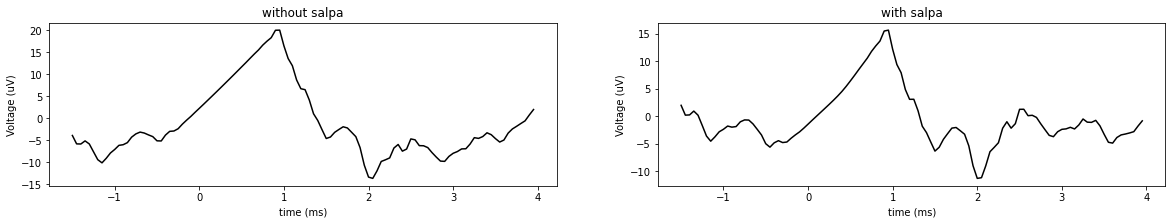

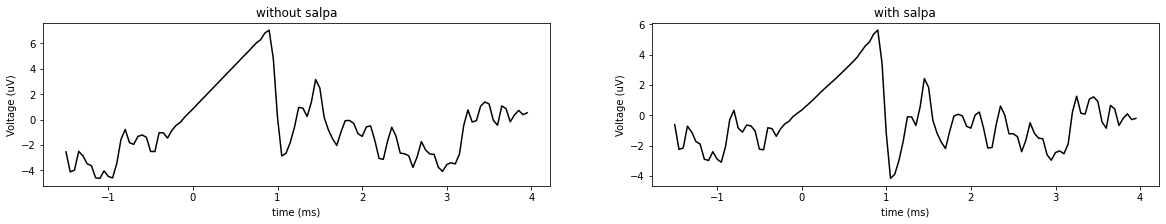

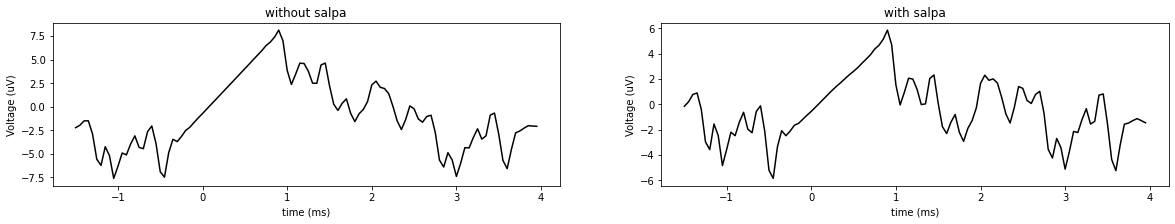

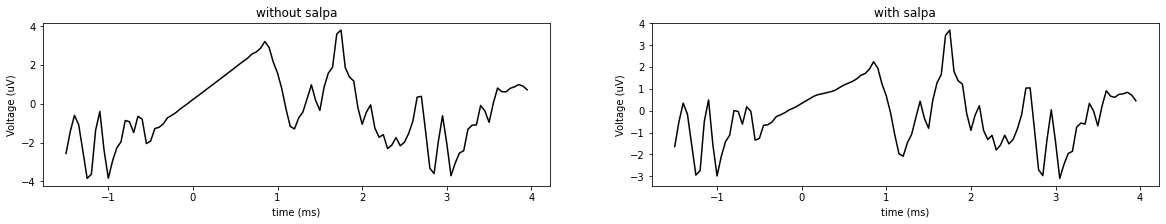

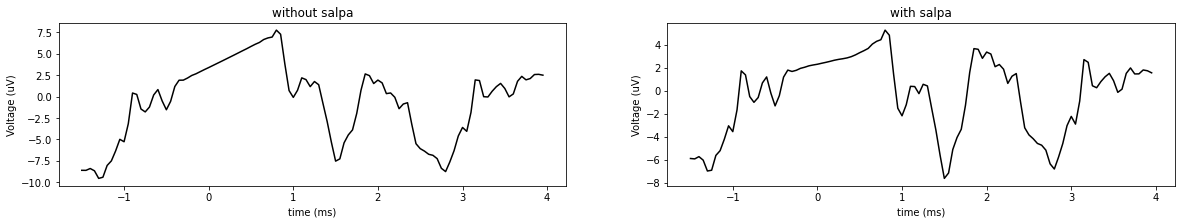

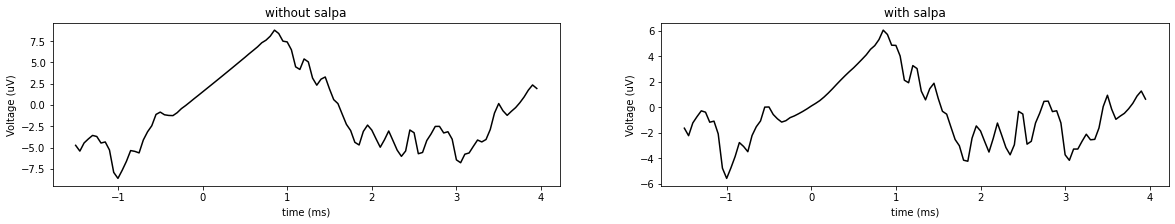

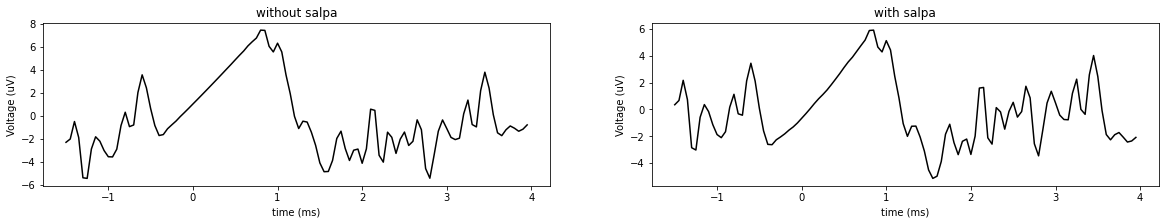

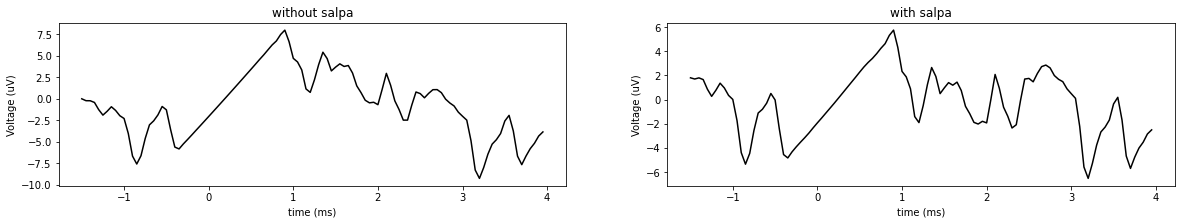

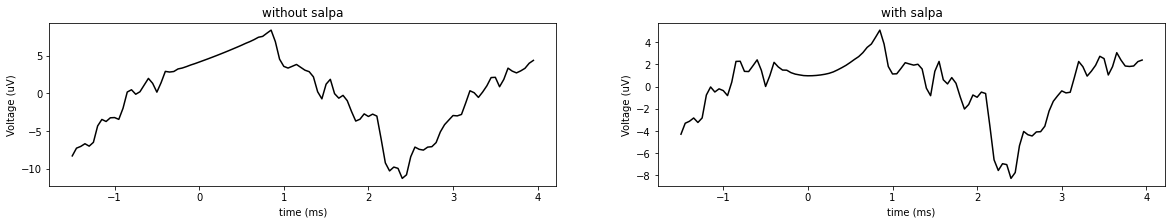

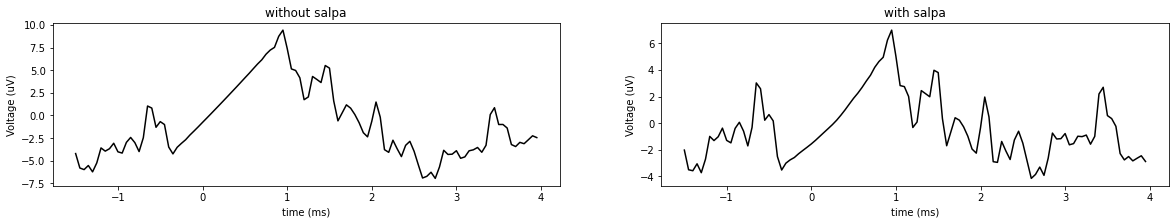

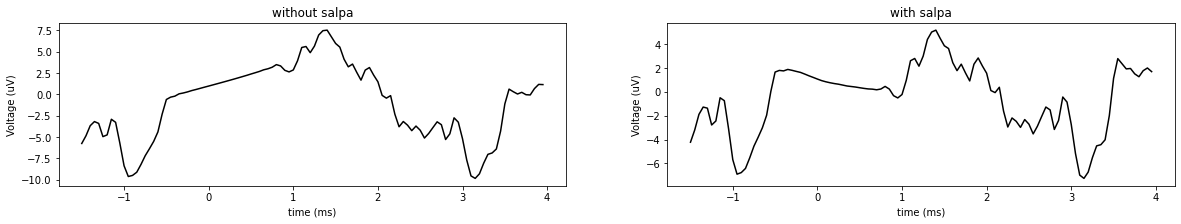

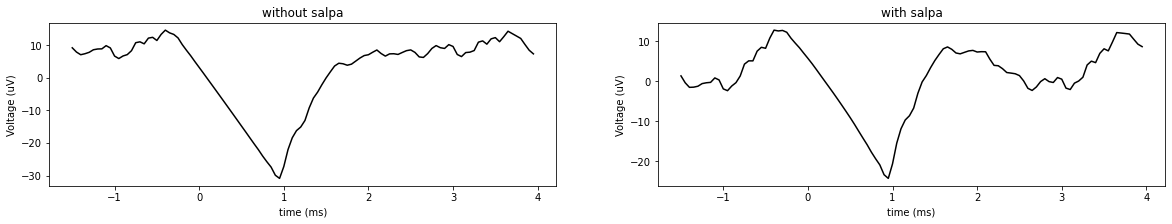

In [13]:
### Visualize Average Post-artefact Power ###

pre_ = -30
post_ = 80
pulse_length = 81
stim_current = 48
stim_id = 'd-000'

sample_time = artefact_times.astype(int)
for rep_num, art_num in enumerate(np.where(np.logical_and(data_info['stim_id'] == stim_id , data_info['stim_current'] == stim_current))[0]):
    plt.figure(figsize=[20,3])
    
    
    sub_signal_orig = np.zeros((post_-pre_))
    band_pass_sub_signal_orig = np.zeros((post_-pre_))
    for pulse in np.arange(num_pulses):
#         sub_signal_orig += np.square(v[sample_time[art_num]-pre_ + pulse*post_:sample_time[art_num]+(pulse+1)*post_])
        band_pass_sub_signal_orig += (v_band_passed1[sample_time[art_num]+pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
        sub_signal_orig += (v_band_passed2[sample_time[art_num]+pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
    
    sub_signal_orig /= num_pulses
    band_pass_sub_signal_orig /= num_pulses
    
    t_ = np.arange(pre_,post_)*1000/samplingFrequency


    plt.subplot(1,2,1)
#     plt.plot(t_,sub_signal_orig, 'r')
    plt.plot(t_,band_pass_sub_signal_orig, 'k', alpha=1)


    plt.title('without salpa')
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (uV)')
    
    plt.subplot(1,2,2)
    plt.plot(t_,sub_signal_orig, 'k', alpha=1)


    plt.title('with salpa')
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (uV)')
    
    plt.show()
    plt.close()
    if rep_num > 10:
        break



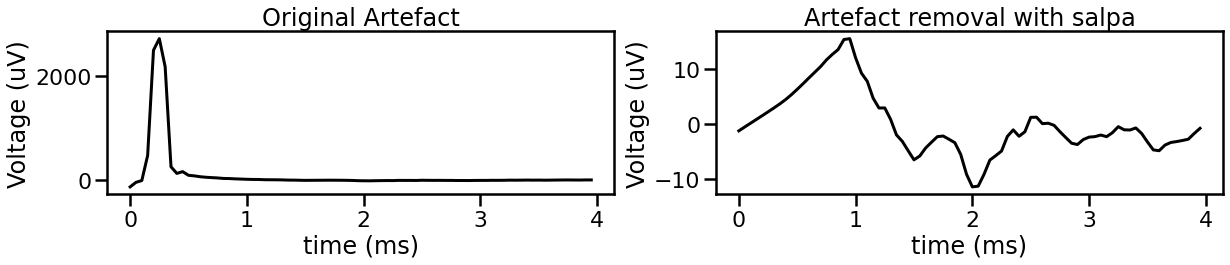

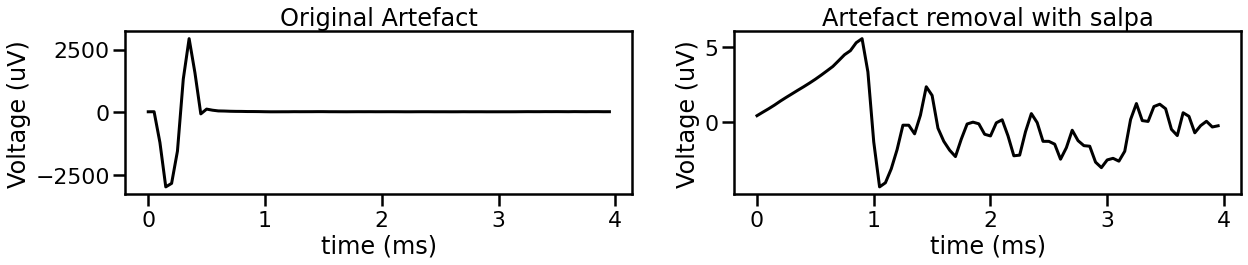

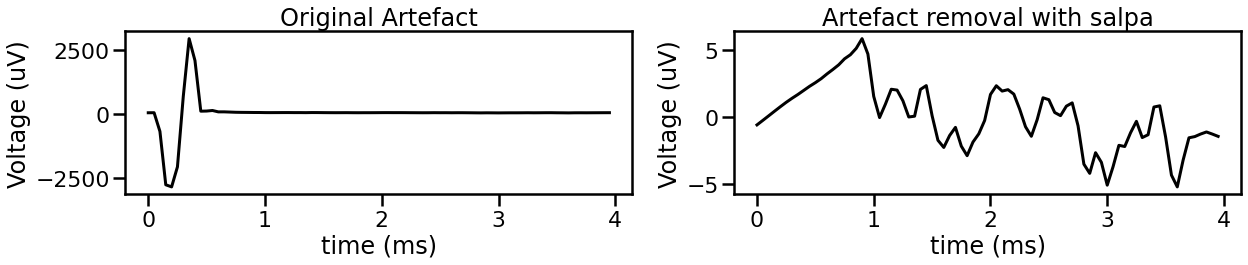

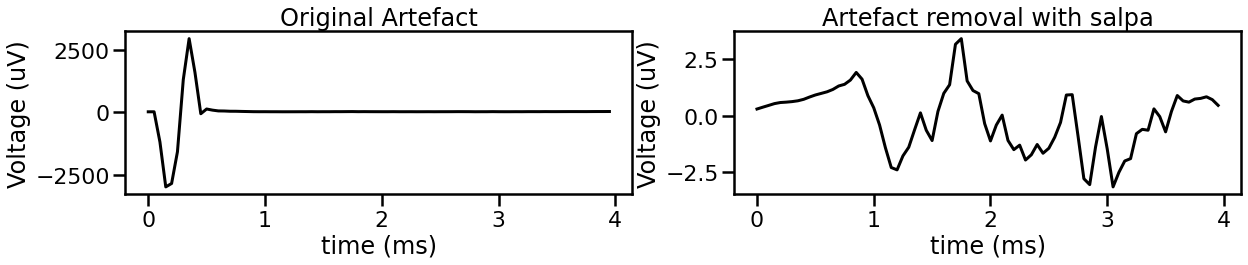

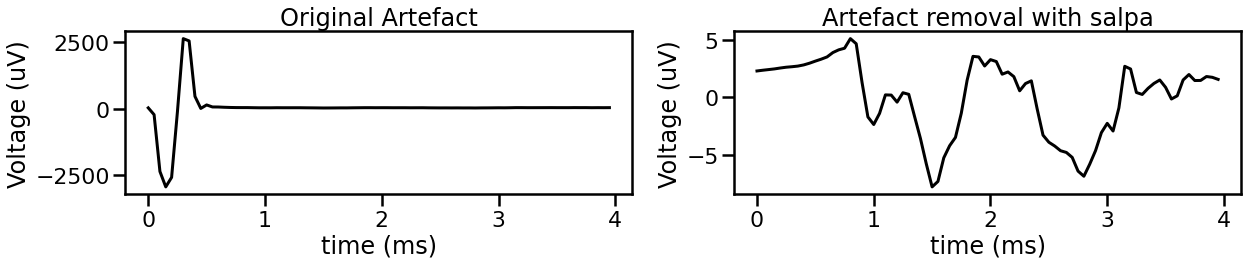

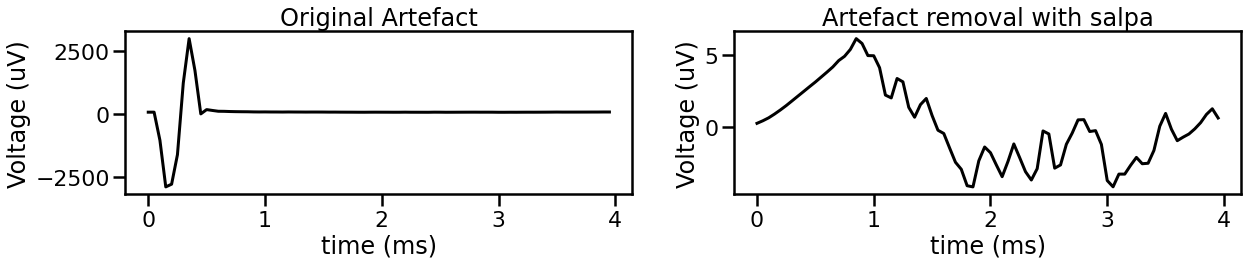

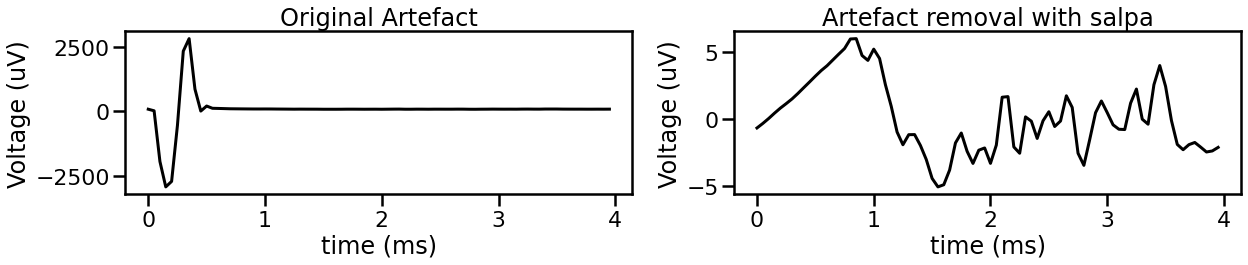

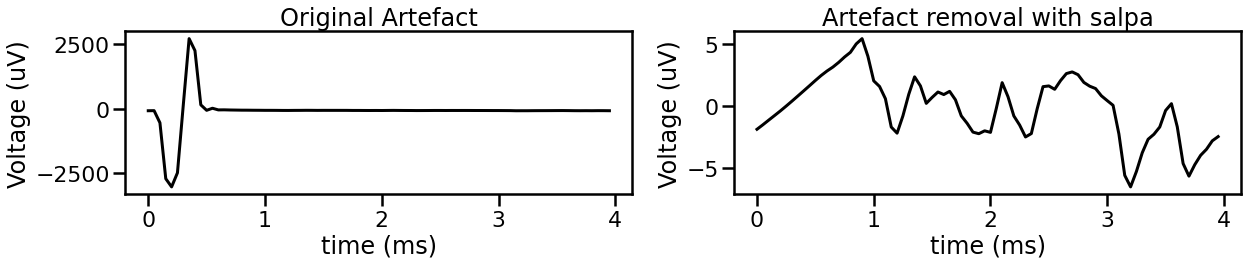

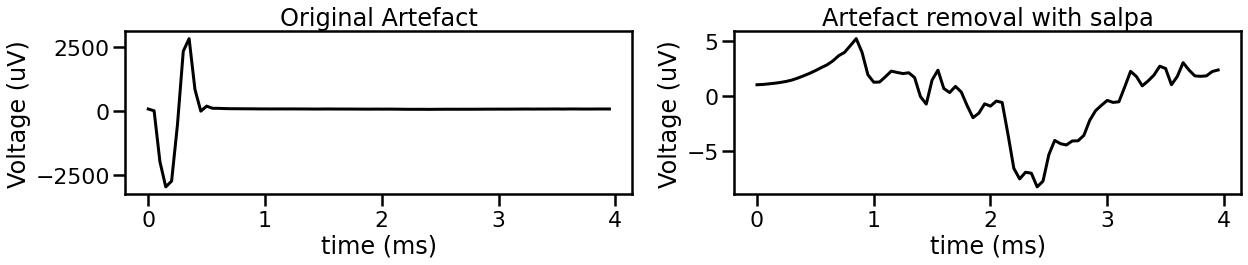

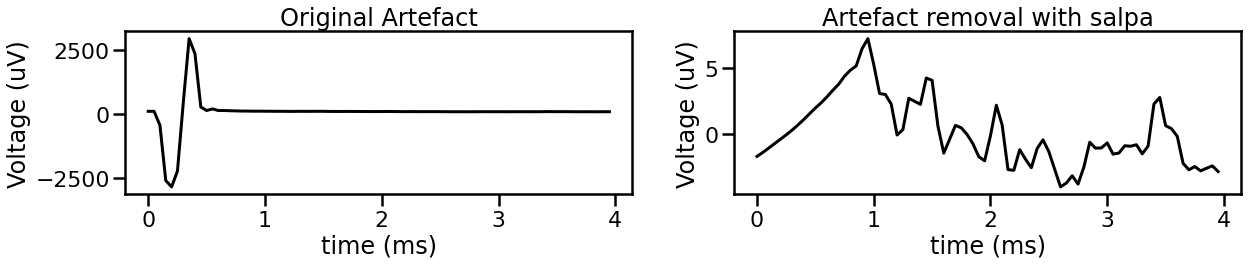

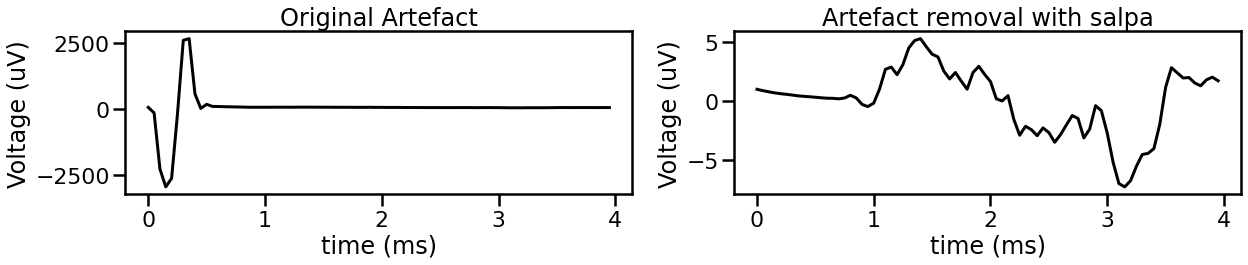

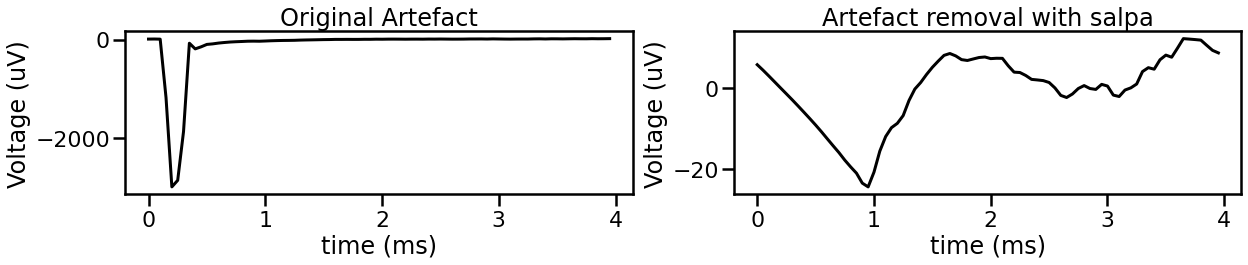

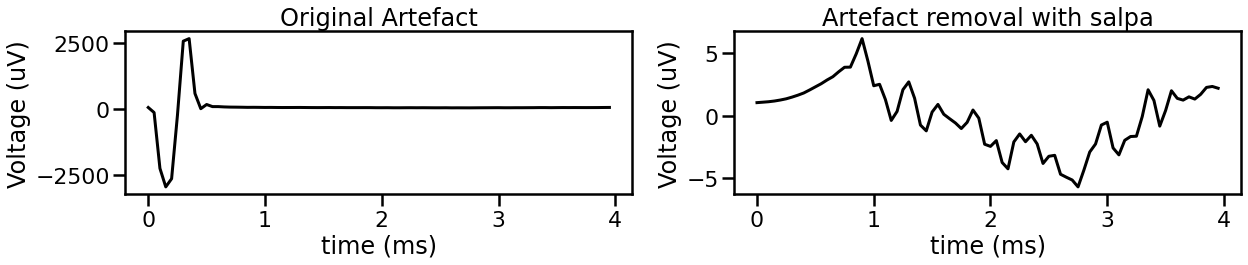

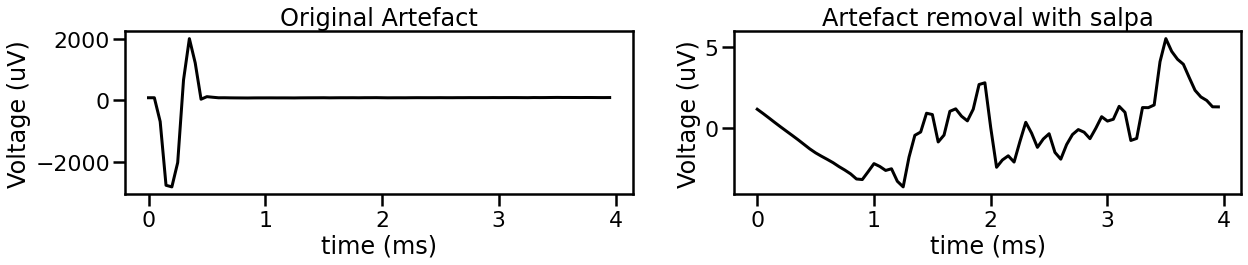

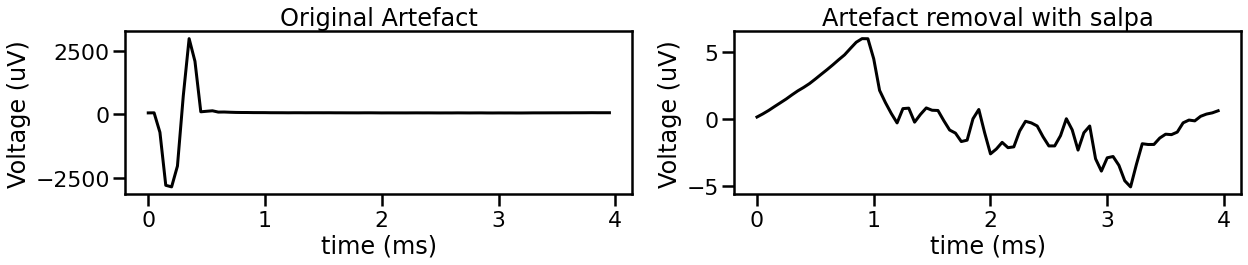

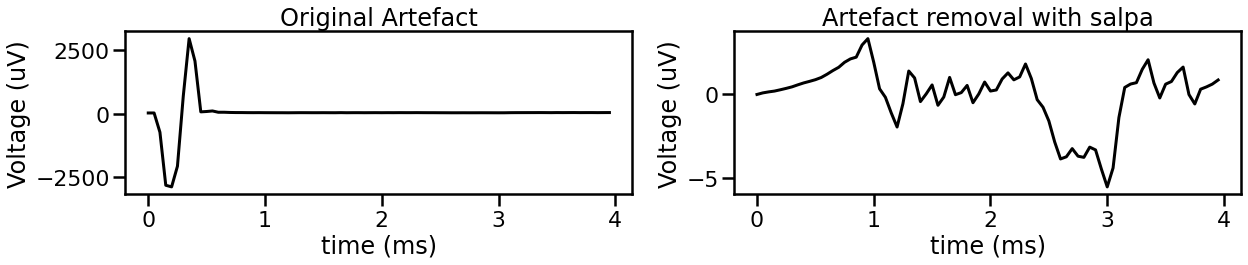

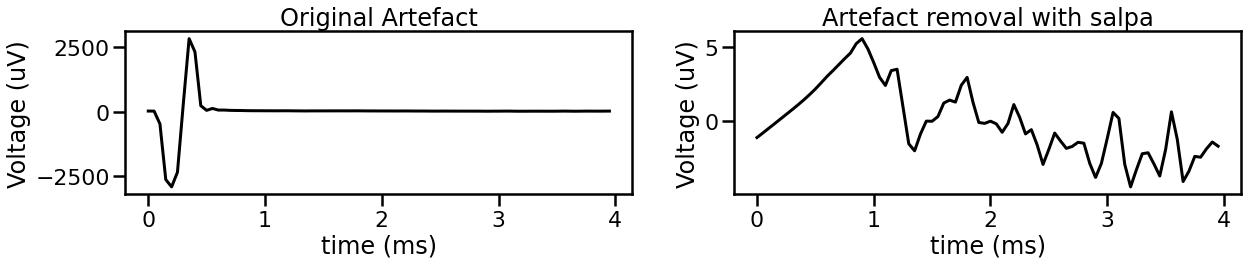

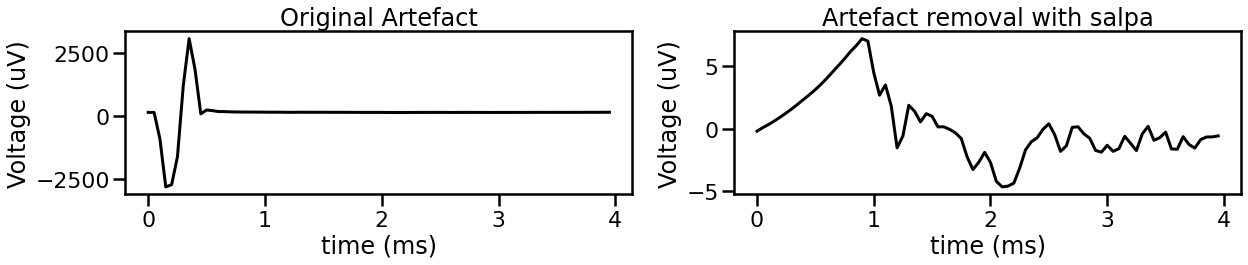

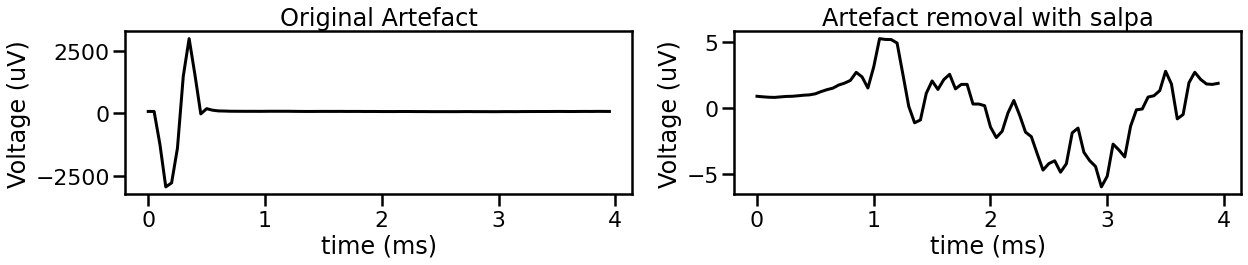

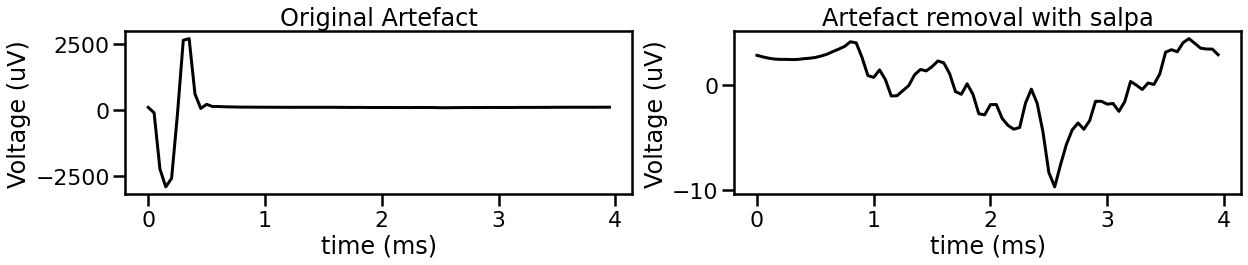

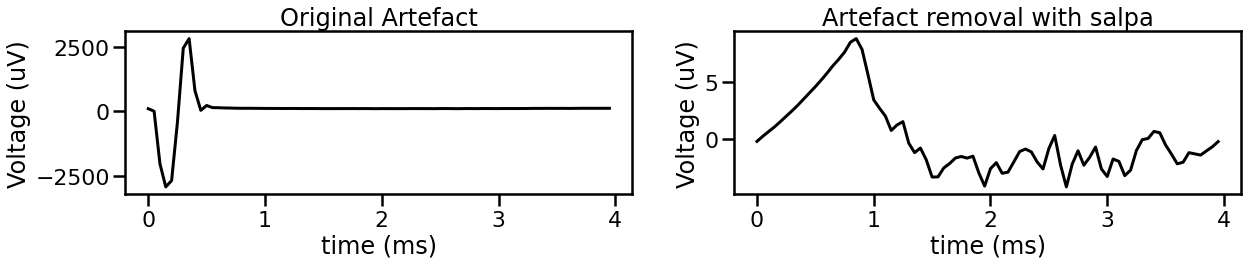

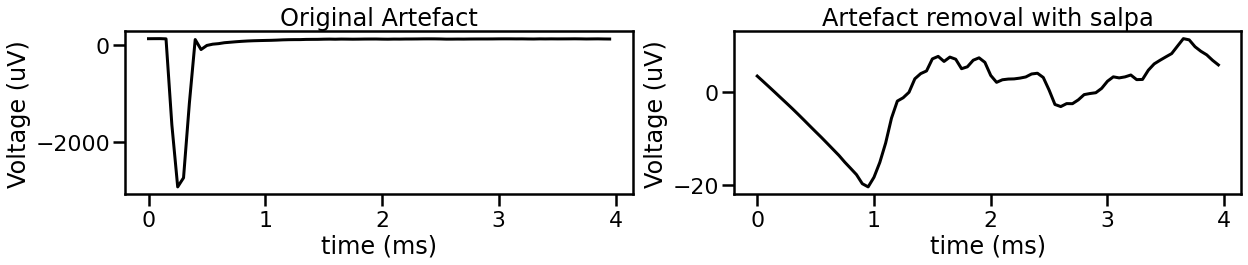

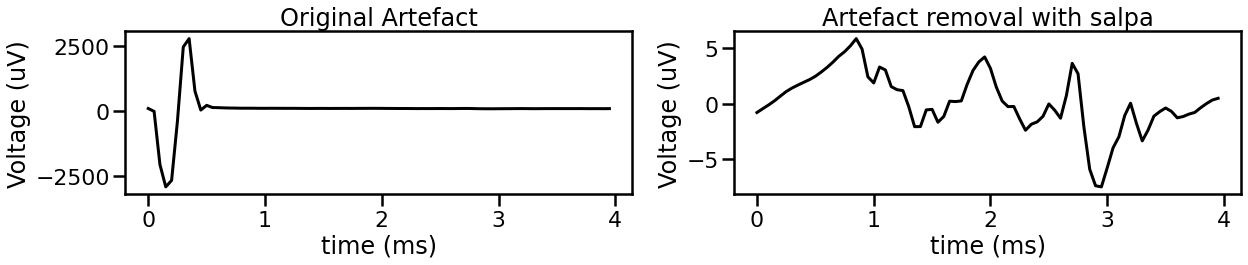

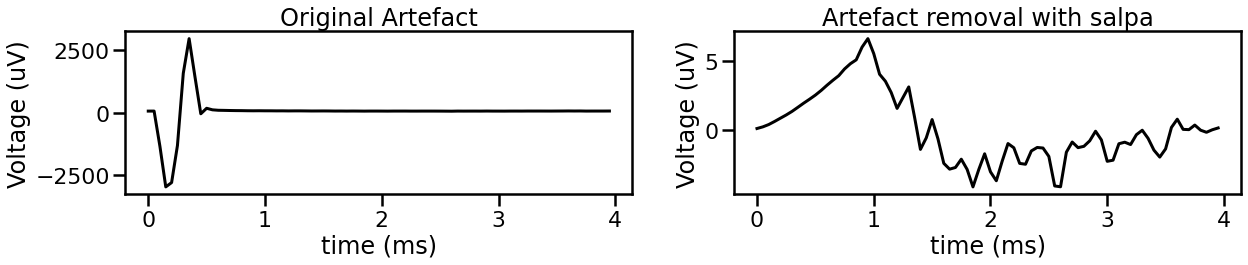

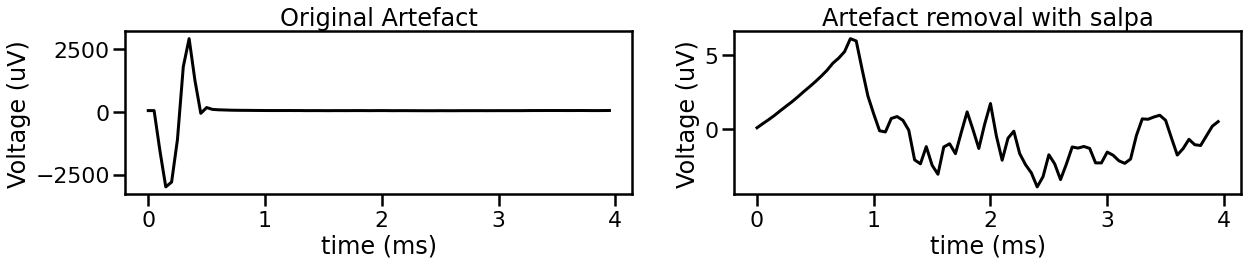

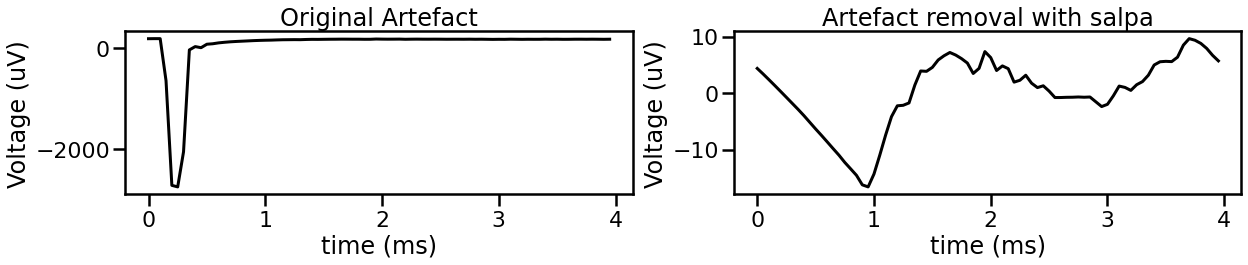

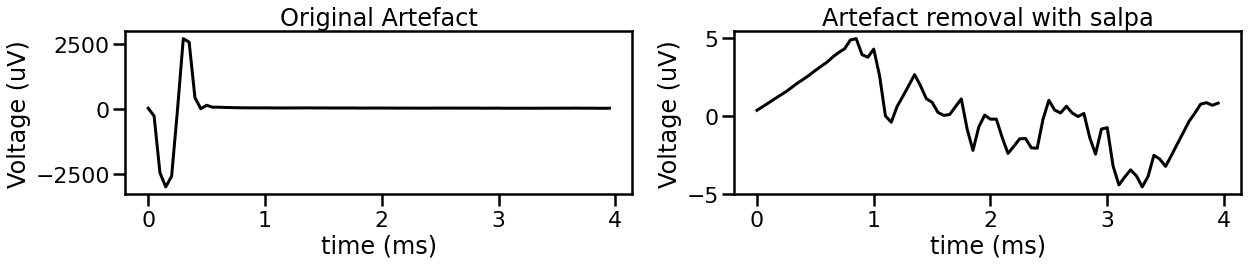

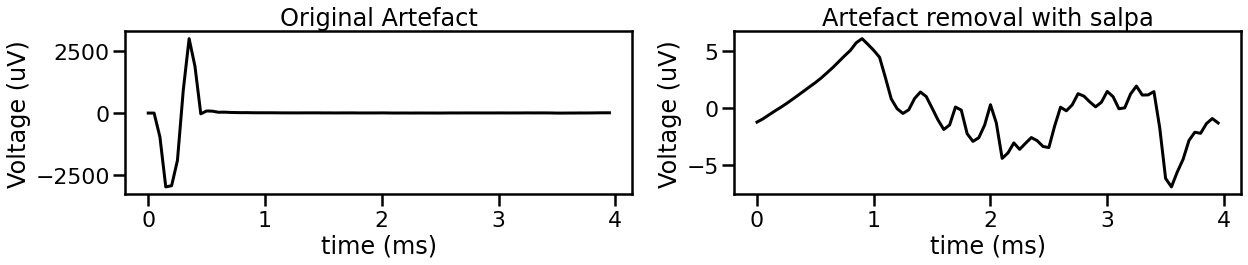

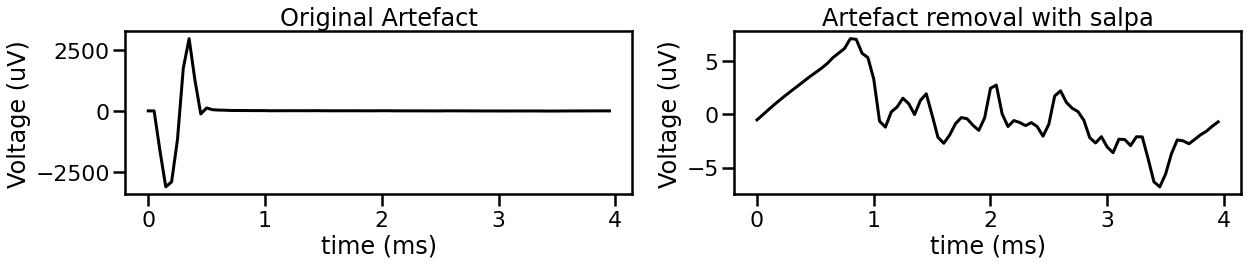

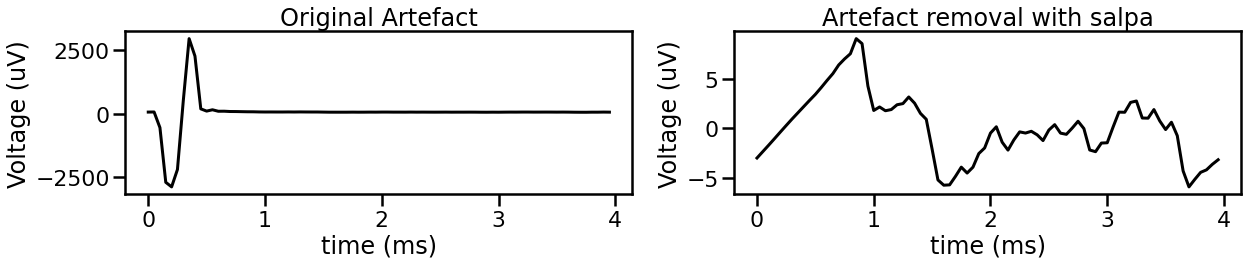

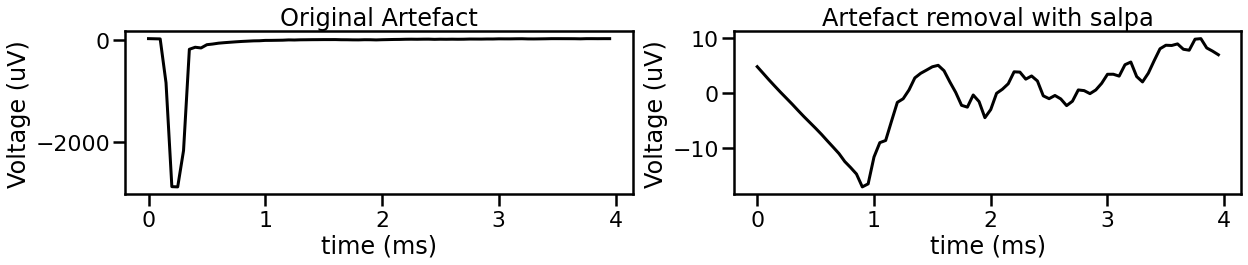

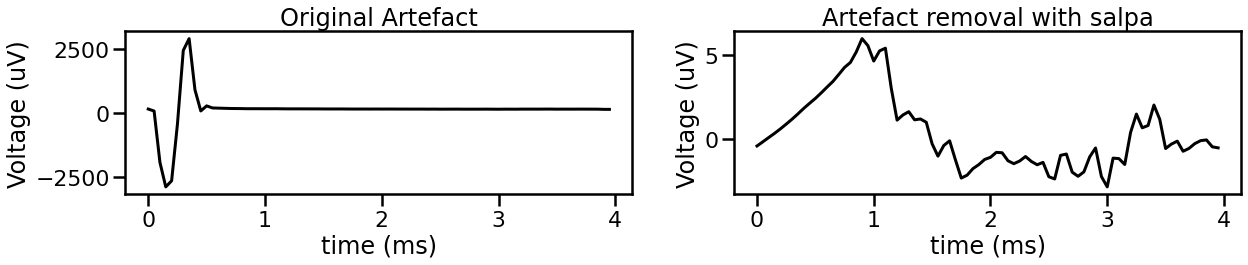

In [290]:
### Visualize Average Post-artefact Power ###

pre_ = 0
post_ = 80
pulse_length = 81
stim_current = 48
stim_id = 'd-000'

sample_time = artefact_times.astype(int)
for rep_num, art_num in enumerate(np.where(np.logical_and(data_info['stim_id'] == stim_id , data_info['stim_current'] == stim_current))[0]):
    plt.figure(figsize=[20,3])
    
    
    sub_signal_orig = np.zeros((post_-pre_))
    band_pass_sub_signal_orig = np.zeros((post_-pre_))
    for pulse in np.arange(num_pulses):
#         sub_signal_orig += np.square(v[sample_time[art_num]-pre_ + pulse*post_:sample_time[art_num]+(pulse+1)*post_])
        band_pass_sub_signal_orig += (v[sample_time[art_num]+pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
        sub_signal_orig += (v_band_passed2[sample_time[art_num]+pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
    
    sub_signal_orig /= num_pulses
    band_pass_sub_signal_orig /= num_pulses
    
    t_ = np.arange(pre_,post_)*1000/samplingFrequency


    plt.subplot(1,2,1)
#     plt.plot(t_,sub_signal_orig, 'r')
    plt.plot(t_,band_pass_sub_signal_orig, 'k', alpha=1)


    plt.title('Original Artefact')
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (uV)')
    
    plt.subplot(1,2,2)
    plt.plot(t_,sub_signal_orig, 'k', alpha=1)


    plt.title('Artefact removal with salpa')
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (uV)')
    
    plt.show()
    plt.close()
    if rep_num > 30:
        break



### Power w.r.t. current ###

In [284]:
### Create Data for plots ###

pre_ = 0
pulse_length = 81
post_ = pulse_length*10


sample_time = artefact_times.astype(int)

samples_with_salpa = []
samples_without_salpa = []

for rep_num, art_num in enumerate(np.arange(len(sample_time))):
        
    samples_without_salpa.append(v_band_passed1[sample_time[art_num]+pre_ :sample_time[art_num]+post_])
    samples_with_salpa.append(v_band_passed2[sample_time[art_num]+pre_ :sample_time[art_num]+post_])

stimulation_pulse_train_df = pd.DataFrame({'id':samp_on_id, 'current':samp_on_current, 'samples_with_salpa':samples_with_salpa, 'samples_without_salpa':samples_without_salpa})

power_current_df = stimulation_pulse_train_df.groupby(['id', 'current']).agg([lambda s: list(s)])

In [285]:
### select window post artefact ###
pre_ = 40
post_ = 70
pulse_length = 81

power_with_salpa = []
power_without_salpa = []

for i in np.arange(len(power_current_df)):
    signal_with_salpa = np.square(np.concatenate(power_current_df.iloc[i]['samples_with_salpa'])).mean(0)
    signal_without_salpa = np.square(np.concatenate(power_current_df.iloc[i]['samples_without_salpa'])).mean(0)
    
    pulse_with_salpa = np.zeros((post_-pre_))
    pulse_without_salpa = np.zeros((post_-pre_))

    for pulse in np.arange(num_pulses):

        pulse_with_salpa += signal_with_salpa[pre_ + pulse*pulse_length: (pulse*pulse_length)+post_]
        pulse_without_salpa += signal_without_salpa[pre_ + pulse*pulse_length: (pulse*pulse_length)+post_]
    
    pulse_with_salpa /= num_pulses
    pulse_without_salpa /= num_pulses
    power_with_salpa.append(np.mean(pulse_with_salpa))
    power_without_salpa.append(np.mean(pulse_without_salpa))

power_current_df['power_with_salpa'] =power_with_salpa
power_current_df['power_without_salpa'] =power_without_salpa

<Figure size 2160x216 with 0 Axes>

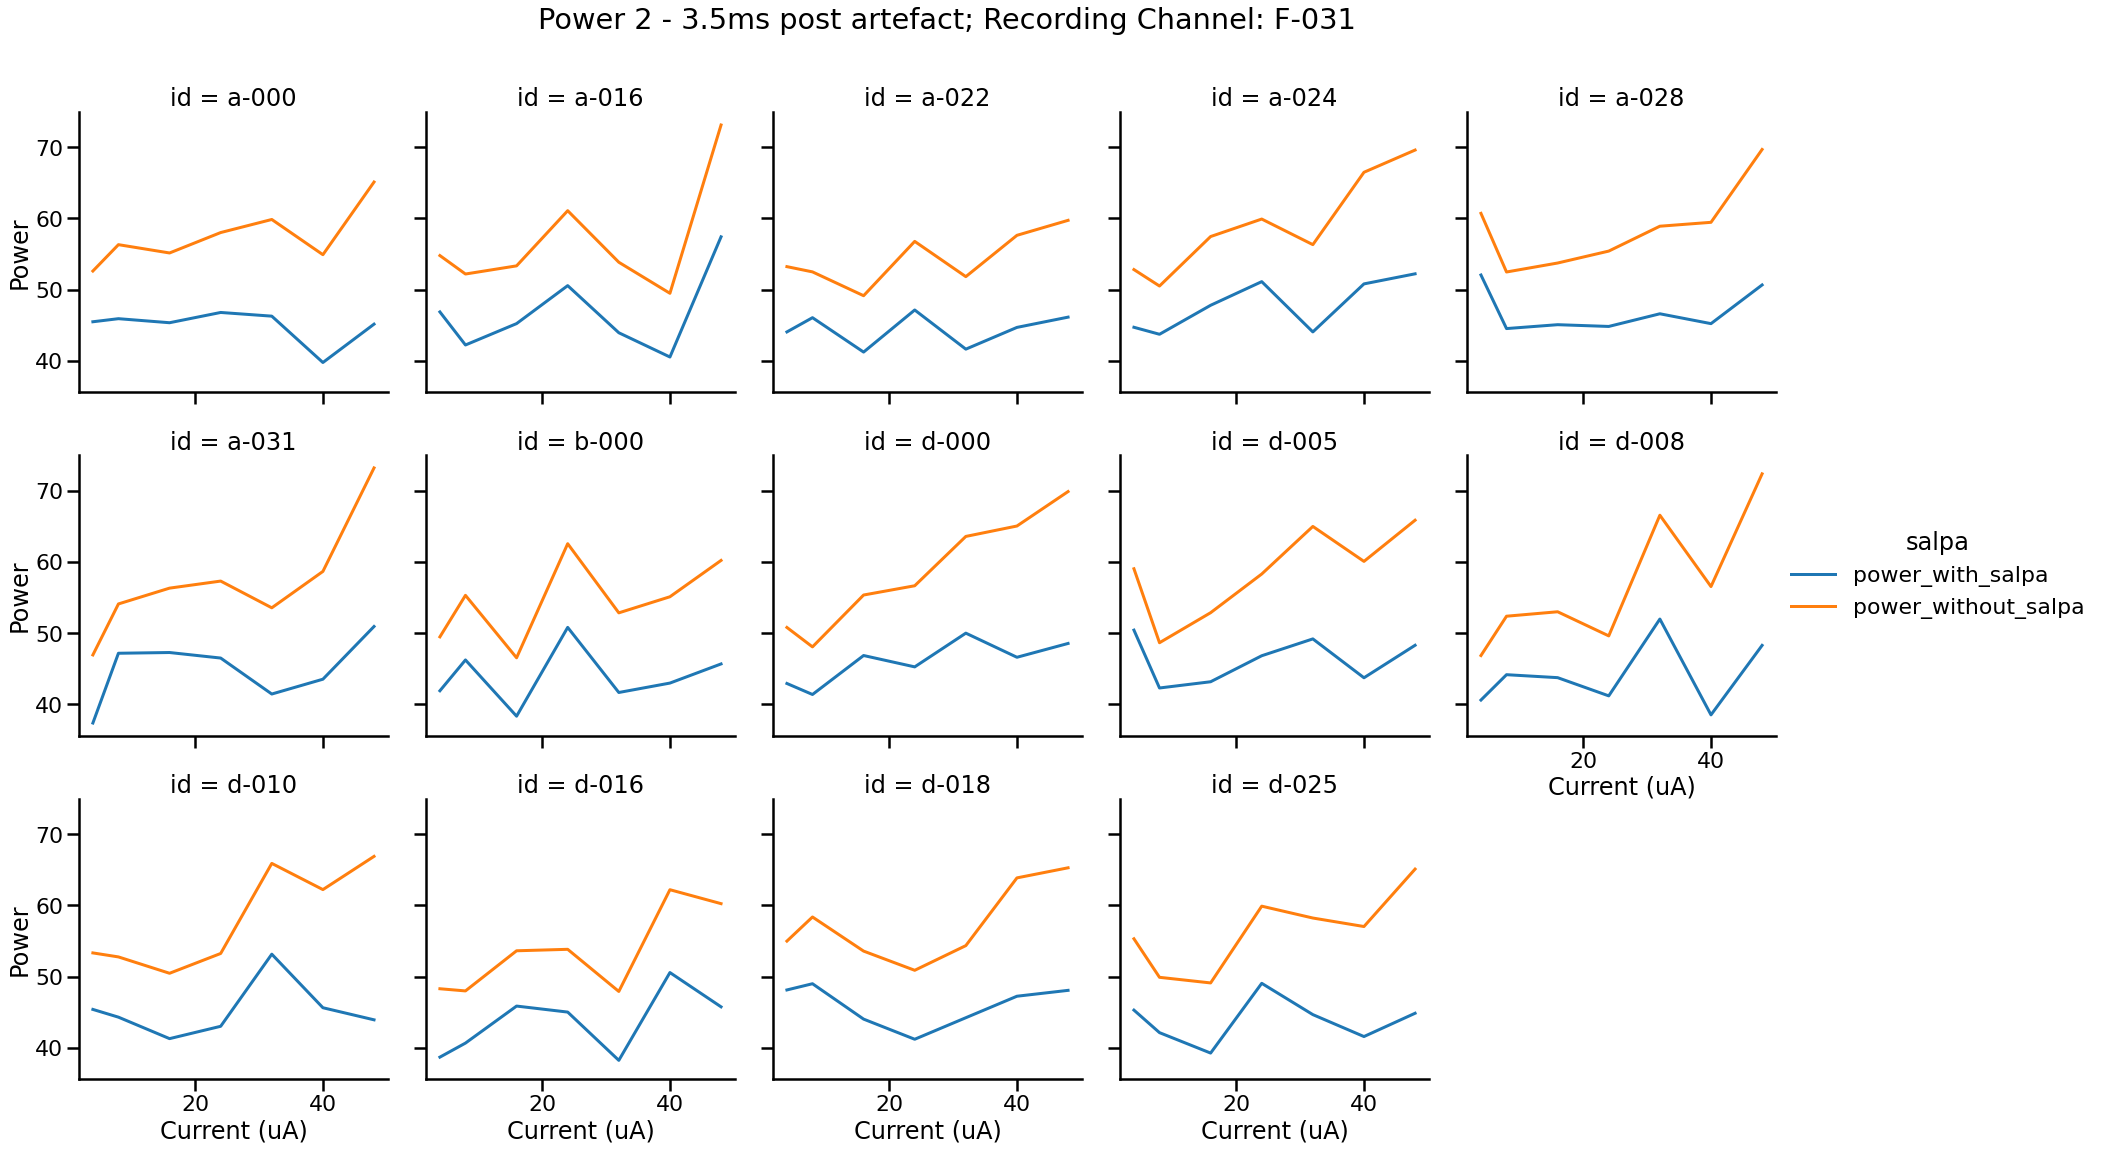

In [286]:
plt.figure(figsize=[30,3])
sns.set_context('poster')
ax = sns.relplot(x='current', y='power',col='id', col_wrap=5, 
            data=pd.melt(power_current_df,  value_vars=['power_with_salpa', 'power_without_salpa'], 
                         var_name='salpa', value_name='power', ignore_index=False, col_level=0), kind='line', hue='salpa')
plt.suptitle('Power 2 - 3.5ms post artefact; Recording Channel: '+recording_channel, x=0.45 ,y=1.05)
ax.set_xlabels('Current (uA)')
ax.set_ylabels('Power')
plt.savefig('Power_post_artefact_2ms_'+recording_channel+'.png', dpi=300, bbox_inches='tight')

# plt.close()

### Consistency post artefactrecording_channel

In [270]:
### Create Data for plots ###

pre_ = 0
post_ = 80
pulse_length = 81
pulse_train_length = pulse_length*10


sample_time = artefact_times.astype(int)


samples_without_salpa = []
samples_with_salpa = []

for rep_num, art_num in enumerate(np.arange(len(sample_time))):
        
    signal_without_salpa = v_band_passed1[sample_time[art_num]+pre_ :sample_time[art_num]+pulse_train_length]
    signal_with_salpa = v_band_passed2[sample_time[art_num]+pre_ :sample_time[art_num]+pulse_train_length]
    pulse_without_salpa = []
    pulse_with_salpa = []
    for pulse in np.arange(num_pulses):
        pulse_without_salpa.append(signal_without_salpa[pre_ + pulse*pulse_length: (pulse*pulse_length)+post_])
        pulse_with_salpa.append(signal_with_salpa[pre_ + pulse*pulse_length: (pulse*pulse_length)+post_])
    
    samples_without_salpa.append(pulse_without_salpa)
    samples_with_salpa.append(pulse_with_salpa)
    
stimulation_pulse_train_df = pd.DataFrame({'id':samp_on_id, 'current':samp_on_current, 'samples_with_salpa':samples_with_salpa, 'samples_without_salpa':samples_without_salpa})

In [233]:
post_artefact_consistency_df = stimulation_pulse_train_df.groupby(['id', 'current']).agg([lambda s: list(s)])

In [245]:
np.concatenate(post_artefact_consistency_df.iloc[0]['samples_with_salpa'])

(61, 10, 80)

In [232]:
# pd.melt(stimulation_pulse_train_df, id_vars=['id', 'current'], value_vars=['samples_with_salpa', 'samples_without_salpa'], 
#                                 var_name='salpa', value_name='signal', col_level=0, ignore_index=False)